In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from cnn_utils import *
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.densenet import DenseNet201
from tensorflow.keras.layers import AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical


## Data Preparation


In [2]:
df = create_dataframe('/../raw_data/dataset_062920.json')
df.head()

,eyeImage,leftEye,rightEye,y
0,"[[[0.49019607843137253, 0.4627450980392157, 0....","[-0.06916704732662149, 0.19730078279591035, -0...","[0.17425771877389162, 0.21639015714266296, 0.2...","[-0.30000000000000004, -0.3019517795637199]"
1,"[[[0.19607843137254902, 0.1607843137254902, 0....","[-0.17658285534307594, 0.18033866676032262, -0...","[0.06629549190581052, 0.1988126179958256, 0.10...","[0.30000000000000004, -0.9012629161882894]"
2,"[[[0.2196078431372549, 0.19215686274509805, 0....","[-0.17382043840055927, 0.17981051564675177, -0...","[0.06089991895895852, 0.18628686237123016, 0.0...","[0.8999999999999999, -0.9012629161882894]"
3,"[[[0.2196078431372549, 0.17647058823529413, 0....","[-0.15968611544730582, 0.18524077990937093, -0...","[0.08123800929222913, 0.1904861112443328, 0.11...","[-0.30000000000000004, 0.8989667049368542]"
4,"[[[0.5882352941176471, 0.5647058823529412, 0.6...","[-0.07825260742468576, 0.16963032408957468, -0...","[0.1666792245722788, 0.19617187288354976, 0.20...","[-0.30000000000000004, 0.2996555683122848]"


In [3]:
len(df)

846

In [4]:
# randomly select training examples
x_train, x_validation, y_train, y_validation = create_train_validation(df)

# generate binary y labels
y_train_binary = create_binary_labels(y_train)
y_validation_binary = create_binary_labels(y_validation) # generate binary y labels
y_train_binary = create_binary_labels(y_train)
y_validation_binary = create_binary_labels(y_validation)

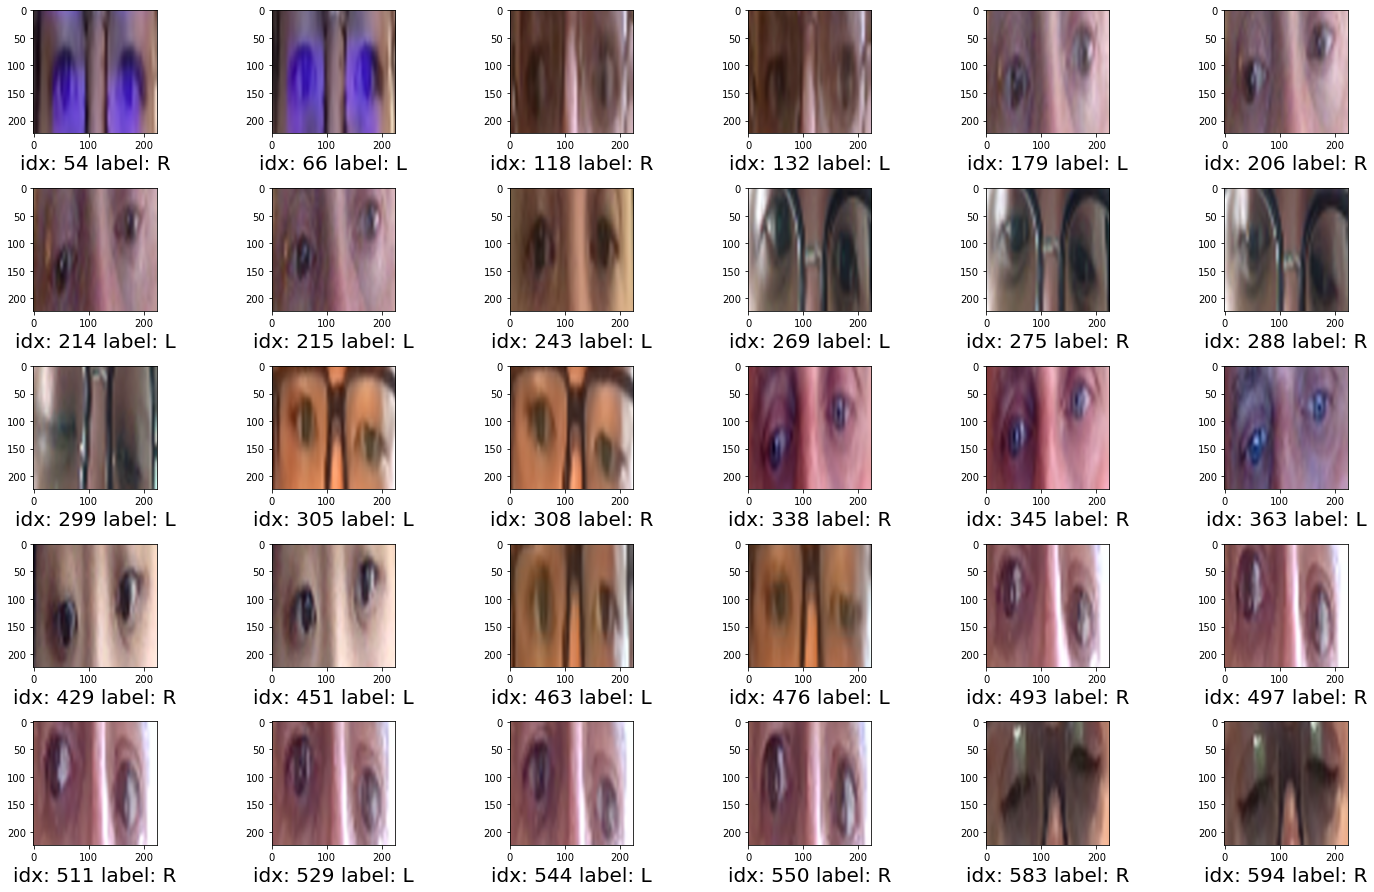

In [5]:
# visualize some data
plot_eyeImages(x_train,y_train_binary)

In [6]:
# prepare data for feeding in CNN
eyeImage_train, leftEye_train, rightEye_train, binary_train = create_tf_data(x_train, y_train_binary)
eyeImage_test, leftEye_test, rightEye_test, binary_test = create_tf_data(x_validation, y_validation_binary)


# encoding the data
binary_encoder = LabelEncoder()
binary_encoder.fit(binary_train)
binary_train = binary_encoder.transform(binary_train)
binary_test = binary_encoder.transform(binary_test)

# one-hot encoding the data
binary_train = to_categorical(binary_train)
binary_test = to_categorical(binary_test)


## ImageNet V2 Transfer Learning

In [7]:
baseModel = MobileNetV2(input_shape= (224, 224, 3), include_top=False, weights='imagenet')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
baseModel.summary()

_relu[0][0]        
__________________________________________________________________________________________________
block_6_depthwise (DepthwiseCon (None, 14, 14, 192)  1728        block_6_pad[0][0]                
__________________________________________________________________________________________________
block_6_depthwise_BN (BatchNorm (None, 14, 14, 192)  768         block_6_depthwise[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]   

Train the last three layers of the mobilenet

In [9]:
for i in range(144):
    baseModel.layers[i].trainable = False

In [10]:
headModel = baseModel.output
headModel = GlobalAveragePooling2D()(headModel)
headModel = Dense(2, activation="softmax")(headModel)



In [11]:
model = Model(inputs=baseModel.input, outputs=headModel)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [12]:
model.summary()

se[0][0]          
__________________________________________________________________________________________________
block_6_depthwise_relu (ReLU)   (None, 14, 14, 192)  0           block_6_depthwise_BN[0][0]       
__________________________________________________________________________________________________
block_6_project (Conv2D)        (None, 14, 14, 64)   12288       block_6_depthwise_relu[0][0]     
__________________________________________________________________________________________________
block_6_project_BN (BatchNormal (None, 14, 14, 64)   256         block_6_project[0][0]            
__________________________________________________________________________________________________
block_7_expand (Conv2D)         (None, 14, 14, 384)  24576       block_6_project_BN[0][0]         
__________________________________________________________________________________________________
block_7_expand_BN (BatchNormali (None, 14, 14, 384)  1536        block_7_expand[0][0]     

In [13]:
# TODO: normalize the input
history_1= model.fit(
	x = eyeImage_train,
	y = binary_train,
    validation_split=0.2,
    batch_size=32,
	epochs=50)


Train on 541 samples, validate on 136 samples
Epoch 1/50
541/541 [==============================] - 37s 69ms/sample - loss: 0.7066 - acc: 0.5804 - val_loss: 0.7166 - val_acc: 0.5000
Epoch 2/50
541/541 [==============================] - 32s 59ms/sample - loss: 0.6624 - acc: 0.7320 - val_loss: 0.7303 - val_acc: 0.4853
Epoch 3/50
541/541 [==============================] - 32s 58ms/sample - loss: 0.6404 - acc: 0.7837 - val_loss: 0.7333 - val_acc: 0.4853
Epoch 4/50
541/541 [==============================] - 32s 60ms/sample - loss: 0.6292 - acc: 0.8281 - val_loss: 0.7369 - val_acc: 0.4853
Epoch 5/50
541/541 [==============================] - 33s 62ms/sample - loss: 0.6097 - acc: 0.8743 - val_loss: 0.7392 - val_acc: 0.4853
Epoch 6/50
541/541 [==============================] - 32s 59ms/sample - loss: 0.5990 - acc: 0.8854 - val_loss: 0.7438 - val_acc: 0.4853
Epoch 7/50
541/541 [==============================] - 35s 64ms/sample - loss: 0.5875 - acc: 0.9150 - val_loss: 0.7447 - val_acc: 0.4853
Ep

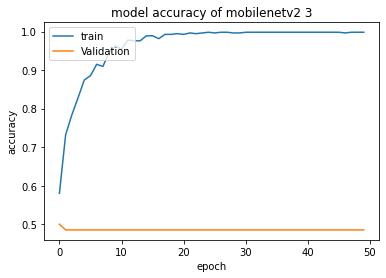

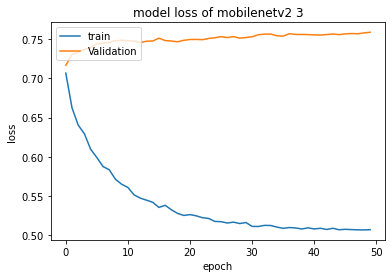

<Figure size 432x288 with 0 Axes>

In [14]:
# summarize history for accuracy
plt.plot(history_1.history['acc'])
plt.plot(history_1.history['val_acc'])
plt.title('model accuracy of mobilenetv2 3')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('results/mobilenetv2_3_acc.png')

# summarize history for loss
plt.plot(history_1.history['loss'])
plt.plot(history_1.history['val_loss'])
plt.title('model loss of mobilenetv2 3')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('results/mobilenetv2_3_loss.png')


In [15]:
history_2 = model.evaluate(eyeImage_test, binary_test)

169/169 [==============================] - 5s 32ms/sample - loss: 0.7599 - acc: 0.4852


## Updated version of `create_tf_data`, July 1, 2020
Substract every image from the average image, every landmarks from the average landmarks positions

### Get the mean image of the training dataset

In [16]:
mean_image = np.mean(eyeImage_train, axis = 0)
# meadian_image = np.median(eyeImage_train, axis = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


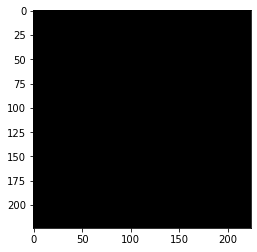

In [17]:
plt.imshow(mean_image)
# plt.savefig("results/average_img.png")

### Updated version of `create_tf_data`

In [18]:
def create_tf_data(X, Y):
    """
    take in the X and Y and transform each column into np array
    Every column in X will be substracted from its mean
    """
    
    eyeImage = np.stack(X['eyeImage'].to_numpy())
    image_mean = np.mean(eyeImage, axis=0)
    eyeImage = eyeImage-image_mean

    leftEye = np.stack(X['leftEye'].to_numpy())
    leftEye_mean = np.mean(leftEye, axis=0)
    leftEye = leftEye-leftEye_mean

    rightEye = np.stack(X['rightEye'].to_numpy())
    rightEye_mean = np.mean(rightEye, axis=0)
    rightEye = rightEye-rightEye_mean

    y = np.stack(Y['y'].to_numpy())
    return eyeImage, leftEye, rightEye, y

### Verify that we substract the mean correctly

In [19]:
_,left,_,_ = create_tf_data(x_train, y_train_binary)

In [20]:
np.sum(left,axis=0)

array([-1.02362563e-13,  1.82076576e-14,  3.19327897e-14,  2.34604003e-14,
       -5.03763697e-15, -1.00475184e-14,  1.93872696e-14, -3.20854454e-14,
       -4.53387328e-14,  7.16648962e-14,  3.74561493e-14, -2.42583731e-14])